In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### The purpose of this notebook is to explore using dgl libaray for GAT implementation

In [2]:
#To use double-precision numbers: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random, vmap#, nn
from patch_gnn.seqops import one_hot
from patch_gnn.graph import graph_tensors,stack_feature_tensors
from patch_gnn.layers import concatenate_node_features,get_norm_attn_matrix,softmax_on_non_zero
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import jax.numpy as jnp
import numpy as np
from tqdm import tqdm

pd.set_option('display.max_rows', 100)
from jax.config import config 
config.update("jax_debug_nans", True)

#### Get all relevant graphs

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

#train_df, test_df = train_test_split(key, processed_data)
#print(len(train_df), len(test_df))

# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


In [8]:
len(set(list(graphs.keys())))

359

##### Convert networkx graphs to dgl graph objects, then put it into a dataset

In [5]:
from patch_gnn.dgl_dataset import get_graph_and_feat_df,convert_networkx_to_dgl,PatchGNNDataset

Using backend: pytorch


In [6]:
#torch.tensor(all_graph_features[0])

In [7]:
all_networkx_graphs, all_graph_features = get_graph_and_feat_df(graphs, processed_data)
all_networkx_graphs = [graph.to_directed() for graph in all_networkx_graphs]
target = processed_data['ox_fwd_logit'].values
dataset = PatchGNNDataset(
                 networkx_graphs= all_networkx_graphs,
                 labels = target,
                 features= all_graph_features)


100%|██████████| 359/359 [00:00<00:00, 3364.25it/s]


In [8]:
# indexing datasets returns dgl_graph, target value and node names
one_dgl_graph, one_graph_node, one_graph_features, one_graph_label = dataset[4]

print(f"dataset 0 nodes is {one_graph_node}, target is {one_graph_label}")
one_dgl_nodes = list(one_graph_node.values())

dataset 0 nodes is {0: '402CYS', 1: '405ILE', 2: '409LEU', 3: '437ASP', 4: '438MET', 5: '439ILE', 6: '442TRP', 7: '573LEU', 8: '576ILE'}, target is -3.8092901706695557


In [9]:
list(one_graph_node.values())

['402CYS',
 '405ILE',
 '409LEU',
 '437ASP',
 '438MET',
 '439ILE',
 '442TRP',
 '573LEU',
 '576ILE']

##### Plot them to varify that the note order, graph structure do not change after this conversion

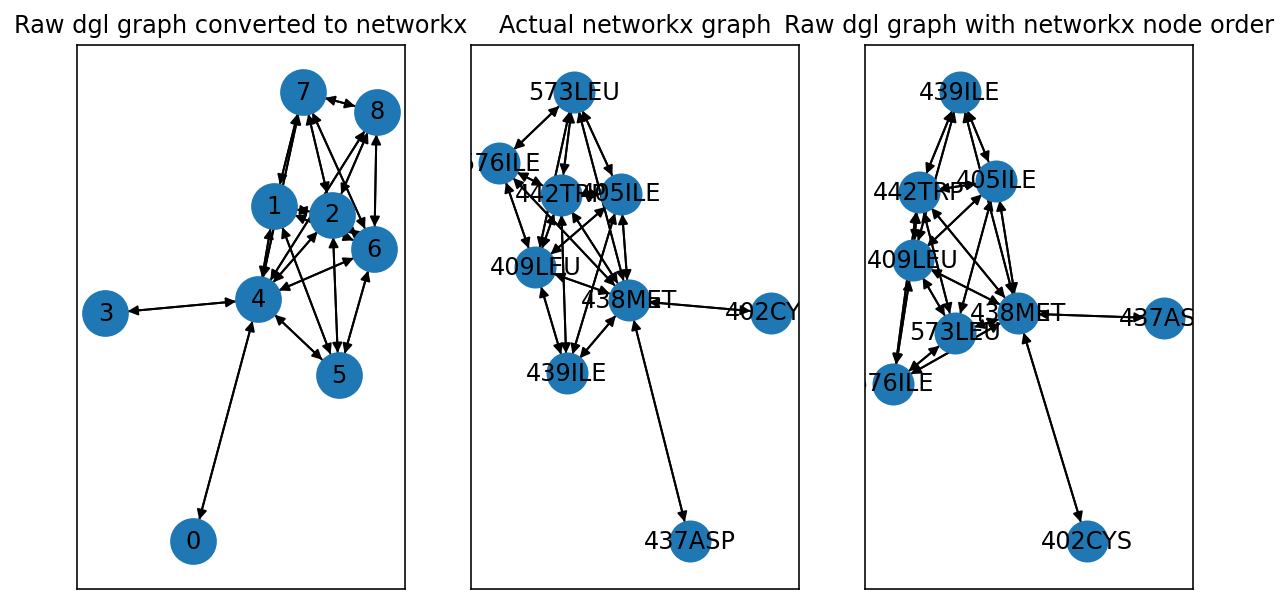

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(131)
newgraph = one_dgl_graph.to_networkx()
plt.title('Raw dgl graph converted to networkx')
nx.draw_networkx(newgraph, with_labels=True, node_size =500)

plt.subplot(132)
plt.title('Actual networkx graph')
nx.draw_networkx(all_networkx_graphs[4], with_labels=True,node_size =400)

plt.subplot(133)
plt.title('Raw dgl graph with networkx node order')
mapping = dict(zip(list(newgraph.nodes()), one_dgl_nodes))
newgraph = nx.relabel_nodes(newgraph, mapping)
nx.draw_networkx(newgraph, with_labels=True,node_size =400)

### When converting nx object to dgl, need to use `Sorted` in networkx_nodes, so that it will appear the same order as its numeric labels

{0: '402CYS', 1: '405ILE', 2: '409LEU', 3: '437ASP', 4: '438MET', 5: '439ILE', 6: '442TRP', 7: '573LEU', 8: '576ILE'}


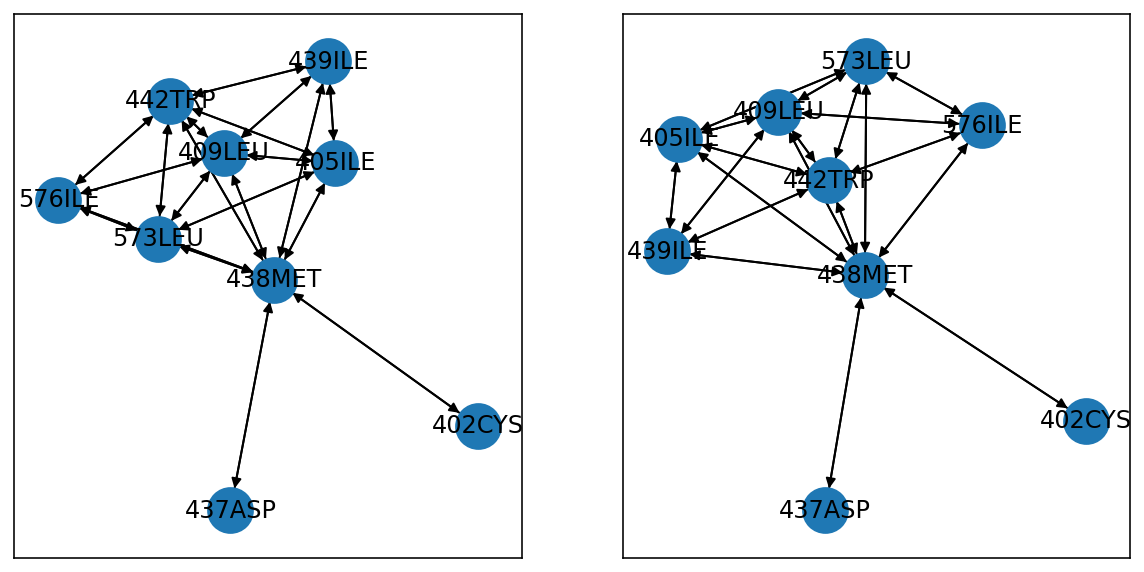

In [11]:
one_nx_graph = all_networkx_graphs[4]
one_nx_graph_feature = all_graph_features[4]
plt.figure(figsize = (10,5))
plt.subplot(121)
nx.draw_networkx(one_nx_graph, with_labels=True, node_size =500)
one_dgl_graph, mapping = convert_networkx_to_dgl(one_nx_graph, one_nx_graph_feature)
plt.subplot(122)
dgl_to_nx = nx.relabel_nodes(one_dgl_graph.to_networkx(), mapping = mapping)
#nx.draw_networkx(one_dgl_graph.to_networkx(), with_labels=True, node_size =500)
nx.draw_networkx(dgl_to_nx, with_labels=True, node_size =500)
print(mapping)

In [12]:
all_graphs = [graph[0] for graph in dataset]
all_feats = [graph[2] for graph in dataset]
all_labels = [graph[3] for graph in dataset]
train_graphs = all_graphs[:251]
test_graphs = all_graphs[251:]
train_feats = all_feats[:251]
test_feats = all_feats[251:]
train_labels = all_labels[:251]
test_labels = all_labels[251:]

In [13]:
len(train_graphs)

251

##### Making GAT layer

In [14]:
# taken from https://github.com/dmlc/dgl/issues/1887
from dgl.nn.pytorch.conv import GATConv
import torch.nn as nn
import torch.nn.functional as F
import torch
from dgl.nn import AvgPooling

class GATN(torch.nn.Module):
    def __init__(self, in_dim, embed_dim, gat_n_heads,
                 gat_out_dim, dense_out1, dense_out2, dense_out3):
        super(GATN, self).__init__()
        self.dense = nn.Linear(in_dim, embed_dim)
        self.gatlayer = GATConv(embed_dim, gat_out_dim, gat_n_heads)
        self.poolinglayer = AvgPooling()
        self.dense1 = nn.Linear(gat_out_dim*gat_n_heads, dense_out1)
        self.dense2 = nn.Linear(dense_out1, dense_out2)
        self.dense3 = nn.Linear(dense_out2, dense_out3)
        
    # there are multiple disconnected graph, will be easier to think of them as ind graph (one graph)
    def forward(self, graph, feature):  
        h = self.dense(feature) # (graph_sample_size, in_dim) --> (graph_sample_size, embed_dim)
        #print(f"h after embedding is {h.size()}")
        h, atten = self.gatlayer(graph, h, get_attention = True) #--> h: (n_nodes, num_heads, gat_out_dim)
        #print(f"h size after gat is {h.size()}")
        h = h.flatten(start_dim =1) #(n_nodes, gat_out_dim*num_heads ) 
        # add graph summation across 1st axis - axis 0
        h = self.poolinglayer(graph, h) # (batch_size, gat_out_dim*num_heads)
        # use sumlayer insteadh = torch.sum(h, dim=0)
        #print(f"h size after summation is {h.size()}")
        h = F.elu(h)
        h = self.dense1(h)
        h = F.elu(h)
        h = self.dense2(h)
        h = F.elu(h)
        h = self.dense3(h)
        
        return h, atten
            

In [87]:
from dgl.dataloading import GraphDataLoader


In [107]:
def collate_fn(samples):
    #print(samples, type(samples))
    graphs, dict_name, labels = map(list, zip(*samples)) #combine each position into graphs, dict_names, labels
    batch_graph = dgl.batch(graphs)
    return batch_graph, torch.tensor(labels)

In [108]:
loader = GraphDataLoader(dataset, batch_size = 32, collate_fn =collate_fn)

In [109]:
for i in loader:
    print(i)
    break
#next(iter(loader))

(Graph(num_nodes=270, num_edges=1144,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float64)}
      edata_schemes={}), tensor([-4.5387, -3.2780, -3.1512, -2.7817, -3.8093, -1.5651, -3.7181, -2.6691,
        -4.3897, -4.2601, -2.3003, -0.8488, -2.3975, -2.1217, -1.3491, -1.4967,
        -1.9099, -1.8440, -4.1588, -2.5672, -2.8543, -4.5951, -2.9095, -2.5325,
        -4.5951, -3.1954, -3.5254, -2.0288, -1.7902, -1.9648, -0.5785, -2.1530]))


In [ ]:
torch.tensor

In [38]:
# use tensorboard: https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
from tensorboardX import SummaryWriter
writer = SummaryWriter()

# create the model
net = GATN(in_dim = 67, embed_dim = 96, gat_n_heads =1,
          gat_out_dim = 64, dense_out1 = 128, dense_out2 =64, dense_out3 =1)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# training main loop
for epoch in tqdm(range(2000)):
    pred_lst = list()
    atten_lst = list()
    mseloss_list = list()
    # start training
    #batch size is 1 here
    for graph_idx in (range(len(train_graphs))):
        pred_target, atten = net(train_graphs[graph_idx].long(), 
                             train_feats[graph_idx])
    
        
        # compute loss for each batch - shouldn't compute loss for the entire dataset, right?
        mse_loss = nn.MSELoss()
        # both pred and train labels are tensor.size([1])
        actual_loss = mse_loss(pred_target.float(), train_labels[graph_idx].float().unsqueeze(0))
        
        # backward
        #need to set gradient to zero first https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()
        actual_loss.backward()
        optimizer.step()

        pred_lst.append(pred_target.detach().numpy())
        atten_lst.append(atten)
        mseloss_list.append(actual_loss.detach().numpy())
    #print(mseloss_list)
    writer.add_scalar("mean_MSELoss/train", np.mean(mseloss_list), epoch)
    writer.add_scalar("variance explained/train", evs(train_labels, pred_lst))
    #print(evs(train_labels, pred_lst))

    # predict
    if epoch >500:
        pred_test_lst = list()
        atten_test_lst = list()
        mseloss_test_list = list()
        for test_graph_idx in (range(len(test_graphs))):

            pred_target_test, atten_test = net(test_graphs[test_graph_idx].long(), 
                                 test_feats[test_graph_idx])
            # compute loss for each batch - shouldn't compute loss for the entire dataset, right?
            # both pred and test labels are tensor.size([1])
            actual_test_loss = mse_loss(pred_target_test.float(), 
                                        test_labels[test_graph_idx].float().unsqueeze(0))
            pred_test_lst.append(pred_target_test.detach().numpy())
            atten_test_lst.append(atten_test)
            mseloss_test_list.append(actual_test_loss.detach().numpy())
        #print(f"len of pred is {len(pred_test_lst)}")
        writer.add_scalar("mean_MSELoss/test", np.mean(mseloss_test_list), epoch)
        writer.add_scalar("variance explained/test", evs(test_labels, pred_test_lst))
            
            
        
        
    
writer.flush()
writer.close()    
    

100%|██████████| 2000/2000 [31:37<00:00,  1.05it/s]


In [33]:
len(test_graphs)

108

In [ ]:
pred_target.shape, atten.shape

In [ ]:
type(train_labels)

In [20]:
writer.flush()
writer.close()

In [85]:
dataset[4][0].ndata["feat"][:5,:5]

tensor([[  1.7100,  10.7800,   8.3300,   5.0200, 121.0000],
        [  2.3200,   9.7600,   7.0000,   6.0400, 131.0000],
        [  2.3600,   9.6000,   7.0000,   6.0400, 131.0000],
        [  1.8800,   9.6000,   3.6500,   2.9800, 133.0000],
        [  2.2800,   9.2100,   7.0000,   5.7400, 149.0000]],
       dtype=torch.float64)

In [86]:
dataset[4][2][:5,:5]

tensor([[  1.7100,  10.7800,   8.3300,   5.0200, 121.0000],
        [  2.3200,   9.7600,   7.0000,   6.0400, 131.0000],
        [  2.3600,   9.6000,   7.0000,   6.0400, 131.0000],
        [  1.8800,   9.6000,   3.6500,   2.9800, 133.0000],
        [  2.2800,   9.2100,   7.0000,   5.7400, 149.0000]])

In [66]:
import dgl
import numpy as np
import torch as th
from dgl.nn import GATConv
from dgl.nn import AvgPooling
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
g = dgl.add_self_loop(g)
g = dgl.batch([g,g])
feat = th.ones(12, 10) # (n_node, n_feat)
gatconv = GATConv(10, 2, num_heads=3)
res = gatconv(g, feat)
res = res.flatten(start_dim =1)
print(res.shape)
poolinglayer = AvgPooling() 
# graph attention use graph connectivity to perform pooling, if graphs are not connected, it will be viewed as seperated graph
res = poolinglayer(g, res)

res.shape #(#nodes, # heads, outdim is 2)


torch.Size([12, 6])


torch.Size([2, 6])

In [72]:
g.batch_size, g.batch_num_nodes()

(2, tensor([6, 6]))

In [59]:
res.flatten(start_dim =1)

tensor([[-3.5663,  2.9010,  0.5635, -1.3641],
        [-3.5663,  2.9010,  0.5635, -1.3641],
        [-3.5663,  2.9010,  0.5635, -1.3641],
        [-3.5663,  2.9010,  0.5635, -1.3641],
        [-3.5663,  2.9010,  0.5635, -1.3641],
        [-3.5663,  2.9010,  0.5635, -1.3641]], grad_fn=<ViewBackward>)

In [55]:
g.in_degrees(),feat

(tensor([2, 2, 2, 3, 2, 1]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

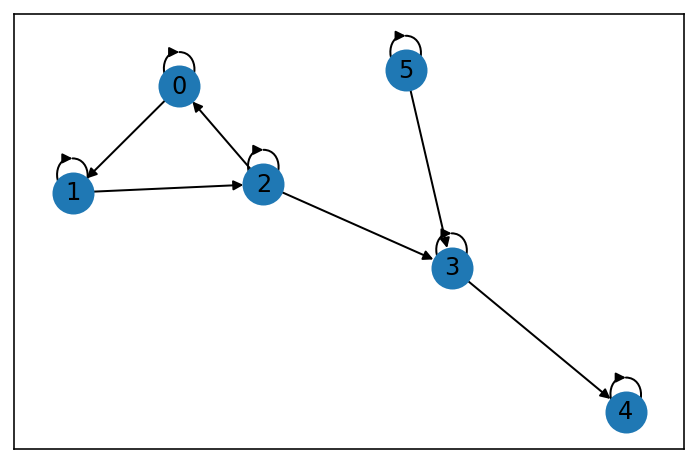

In [54]:

nx.draw_networkx(g.to_networkx(), with_labels=True,node_size =400)

In [ ]:
atten = atten.squeeze()

In [ ]:
all_graphs[2].edges(form = "uv")[0],all_graphs[2].edges(form = "uv")[1]

### draw attention plot

In [ ]:
import seaborn as sns
labels = list(sorted(all_networkx_graphs[2].nodes()))
labels
from numpy.random import default_rng
#https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
a =np.zeros((len(labels),len(labels)))#default_rng(42).random((len(labels),len(labels)))
for i in range(len(all_graphs[2].edges(form = "uv")[0])):
    a[all_graphs[2].edges(form = "uv")[0][i], all_graphs[2].edges(form = "uv")[1][i]] =  atten[i]

sns.heatmap(a,
                xticklabels = labels, 
                yticklabels= labels)

In [ ]:
b = pd.DataFrame(a)
b

In [ ]:
#dgl_to_nx = nx.relabel_nodes(all_graphs[2].to_networkx())
#nx.draw_networkx(one_dgl_graph.to_networkx(), with_labels=True, node_size =500)
nx.draw_networkx(all_graphs[2].to_networkx(), with_labels=True, node_size =500)

In [ ]:
import matplotlib.pyplot as plt

#nx.draw(all_graphs[0].to_networkx(), atten.squeeze())
G=nx.Graph()
i=1
G.add_node(i,pos=(i,i))
G.add_node(2,pos=(2,2))
G.add_node(3,pos=(1,0))
G.add_edge(1,2,weight=0.5)
G.add_edge(1,3,weight=9.8)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#nx.draw_networkx(all_graphs[0].to_networkx())

In [ ]:
labels

In [ ]:
atten.tolist()

In [ ]:
dataset[1], pd.DataFrame(all_graph_features[1])

In [ ]:
all_graphs, all_feature = get_graph_and_feat_df(graphs, processed_data)

In [ ]:
len(all_graphs), all_feature[0].shape

In [ ]:
new_entry_list = processed_data["accession-sequence"].reset_index()
#new_entry_list
list(graphs[new_entry_list.loc[0,"accession-sequence"]].nodes())
# the keys in the dict of dgl will be indices

In [ ]:
graphs[new_entry_list.loc[0,"accession-sequence"]].edges()

In [ ]:
pd.DataFrame(all_feature[0]).iloc[:9,:]

In [ ]:
graphs[new_entry_list.loc[1,"accession-sequence"]].nodes()

In [ ]:
pd.DataFrame(all_feature[1]).iloc[[1,3,4],:]

In [ ]:
processed_data["accession-sequence"]

In [ ]:
all_graphs, all_feature = get_graph_and_feat_df(graphs, processed_data)
target = processed_data['ox_fwd_logit'].values

In [ ]:
type(target)

In [ ]:
type(all_feature)

In [ ]:
pd.DataFrame(all_feature[0])

In [ ]:
len(all_graphs), all_feature.shape, taget.shape

In [ ]:
all_graphs[0]

In [ ]:
import dgl

In [ ]:
dgl_graphs = [dgl.from_networkx(graph) for graph in all_graphs]

In [ ]:
dgl_graphs[0]

In [ ]:
dgl.__version__

In [ ]:
# taken from https://github.com/dmlc/dgl/issues/1887
from dgl.nn.pytorch.conv import GATConv
import torch.nn as nn
import torch.nn.functional as F
import torch

class GATDefault(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATDefault, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1)

    def forward(self, g, h):
        h = self.layer1(g, h)
        # Concat last 2 dim (num_heads * out_dim)
        h = h.view(-1, h.size(1) * h.size(2)) # (in_feat, num_heads, out_dim) -> (in_feat, num_heads * out_dim)
        h = F.elu(h)
        h = self.layer2(g, h)
        # Sueeze the head dim as it's = 1 
        h = h.squeeze() # (in_feat, 1, out_dim) -> (in_feat, out_dim)
        return h



In [ ]:
net = GATDefault(
          in_dim=67 ,#features.size(1),
          hidden_dim=128,
          out_dim=64,
          num_heads=1)
print(net)

In [ ]:
#dgl no need to pad 
g = dgl_graphs[0]
features = np.squeeze(all_feature[0])
features = torch.tensor(features[:9,:], dtype =torch.float32)
features.shape
g, features.shape

In [ ]:
len(g.nodes())
#pd.DataFrame(features.numpy())
features = np.squeeze(all_feature[0])
type(features)

In [ ]:
# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    out_from_attention = net(g, features)
    logp = F.linear(out_from_attention, 1)#F.log_softmax(logits, 1) # probably need to change to linear regression
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

In [ ]:
out = net(g, features)
out.shape

In [ ]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx

def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, mask
g_exam, features_exam, labels_exam, mask_exam = load_cora_data()


In [ ]:
g_exam,features_exam.shape

In [ ]:
features_exam.shape

In [ ]:
# how to make my dataset: https://docs.dgl.ai/tutorials/blitz/6_load_data.html#sphx-glr-tutorials-blitz-6-load-data-py
#https://bitbucket.prd.nibr.novartis.net/projects/CHEMGNN/repos/chemgnn/browse

In [ ]:
import dgl
from dgl.data import DGLDataset
import torch
import os
from typing import List, Optional
import networkx as nx
from tqdm import tqdm
from patch_gnn.dgl_dataset import get_graph_and_feat_df

def convert_networkx_to_dgl(one_networkx_graph:nx.Graph, one_graph_feature:np.ndarray):
    """
    Convert one networkx graph to dgl graph
    :param one_networkx_graph: one nx.Graph
    :param one_graph_feature: ndarray of shape (n_node, m_features), n_node could vary in length
                              n_node match to the correpsonding num of nodes in one_networkx_graph
    """
    dgl_graph = dgl.from_networkx(one_networkx_graph)
    dgl_graph.ndata['feat'] = torch.from_numpy(one_graph_feature)
    return dgl_graph
    

class PatchGNNDataset(DGLDataset):
    def __init__(self,
                 name: str = 'ghesquire_2011',
                 networkx_graphs: List[nx.Graph] = None,
                 labels: np.ndarray = None,
                 features: List[np.ndarray] = None,
                 networkx_to_dglgraph: callable = convert_networkx_to_dgl):
        """
        init this class
        :params networkx_graph: a list of graphs in networkx format
        :params labels: the target of prediction
        :features: a list, each element is a feature matrix of the corresponding graph from networkx_graph, 
                    should be of shape (n_node, m_features) with no padding. n_node varies for each graph,
                    m_features is fixed for all graphs.         
        """
        self.networkx_graphs = networkx_graphs
        self.features = features
        self.labels = torch.from_numpy(labels)
        self.nodenames = [list(graph.nodes()) for graph in networkx_graphs]
        super().__init__(name= name)

    def process(self):
        # convert networkx_graphs to dgl graphs
        dgl_graphs = []
        for idx in tqdm(range(len(self.networkx_graphs))):
            dgl_graphs.append(convert_networkx_to_dgl(self.networkx_graphs[idx], self.features[idx]))
            
        self.dgl_graphs = dgl_graphs

    def __getitem__(self, idx):
        return self.dgl_graphs[idx], self.labels[idx], self.nodenames[idx]

    def __len__(self):
        return len(self.dgl_graphs)

all_graphs, all_feature = get_graph_and_feat_df(graphs, processed_data)
target = processed_data['ox_fwd_logit'].values
dataset = PatchGNNDataset(
                 networkx_graphs= all_graphs,
                 labels = target,
                 features= all_feature)


In [ ]:
#all_feature[1].shape
dgl_graph = dgl.from_networkx(all_graphs[0])
dgl_graph.ndata['feat'] = torch.from_numpy(all_feature[0])
dgl_graph

In [ ]:
all_feature[1].shape

In [ ]:
#torch.FloatTensor
#(list(graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()))
graphs['Q9H0U4-MGPGAASGGERPNLK']

In [ ]:
dgl.from_networkx(graphs['Q9H0U4-MGPGAASGGERPNLK'], node_attrs =list(graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()) )

In [ ]:
graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()

In [ ]:
torch.from_numpy(list(graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()).astype('category').cat.codes.to_numpy())

In [ ]:
import networkx as nx
import dgl

#g_nx = nx.petersen_graph()
#g_dgl = dgl.DGLGraph(g_nx)
g_dgl = dgl.from_networkx(graphs['Q9H0U4-MGPGAASGGERPNLK'])
import matplotlib.pyplot as plt
#plt.subplot(121)
#nx.draw(g_nx, with_labels=True)
#plt.subplot(122)
plt.subplot(111)
nx.draw(g_dgl.to_networkx(), with_labels=True)